This notebook takes processed mat/pickle files and makes a dataset for prediction.
In particular, given a history and prediction horizon, this generates all viable slices of a full trajectory.

In [1]:
import glob
import numpy as np
import scipy.io as sio
import pickle
import matplotlib.pyplot as plt
import pdb
from dataset_generator import *

### TODO
* [x] interpolating heading (see interpolate_heading). Added a `np.unwrap()` to prevent possible wrapping around issue
* [x] switch to ego frame (position/orientation are all zero at t = 0). Added a switch in `get_ego_trajectory_prediction_snippets()` function.
* [x] optional: complete outlier removal in bag_processing (see "Additional Notes")
* [ ] VG: If collided, return None and continue the BIG for loop.
* any ideas for dataset quality checking?

### Data Loading

In [2]:
save_ext = 'pkl'
files_to_process = glob.glob('../examples/bags/*.%s' % save_ext)

print('Found %d files to read: %s' % (len(files_to_process), files_to_process))

Found 44 files to read: ['../examples/bags/parking_p2_t2_e3_2019-11-04-16-39-13.pkl', '../examples/bags/parking_p2_t1_e9_2019-11-04-16-35-54.pkl', '../examples/bags/parking_p2_t1_e7_2019-11-04-16-35-13.pkl', '../examples/bags/parking_p2_t1_e0_2019-11-04-16-32-53.pkl', '../examples/bags/parking_p0_t0_e1_2019-11-04-14-22-22.pkl', '../examples/bags/parking_p0_t0_e0_2019-11-04-14-23-51.pkl', '../examples/bags/parking_p2_t2_e1_2019-11-04-16-37-56.pkl', '../examples/bags/parking_p1_t2_e1_2019-11-04-14-40-57.pkl', '../examples/bags/parking_p1_t2_e8_2019-11-04-14-44-50.pkl', '../examples/bags/parking_p2_t2_e0_2019-11-04-16-36-50.pkl', '../examples/bags/parking_p1_t1_e8_2019-11-04-14-37-56.pkl', '../examples/bags/parking_p2_t1_e1_2019-11-04-16-33-19.pkl', '../examples/bags/parking_p1_t2_e4_2019-11-04-14-42-44.pkl', '../examples/bags/parking_p1_t2_e0_2019-11-04-14-40-20.pkl', '../examples/bags/parking_p1_t1_e4_2019-11-04-14-36-16.pkl', '../examples/bags/parking_p2_t1_e2_2019-11-04-16-33-34.pkl',

In [3]:
file_num = 3 # TODO: starting with the first matfile for now
if save_ext == 'mat':
    res_dict = sio.loadmat(files_to_process[file_num], matlab_compatible=True) 
    
elif save_ext == 'pkl':
    res_dict = pickle.load(open(files_to_process[file_num],'rb'))
else:
    raise NotImplemented("Invalid extension.")

In [4]:
goals = extract_goals(res_dict)
ego_trajectory, start_ind, switch_ind, end_ind, goal_ind = extract_full_trajectory(res_dict, goals)


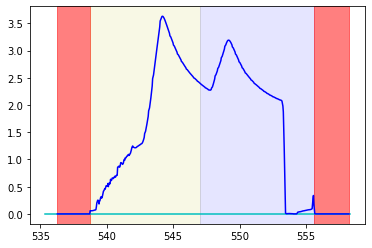

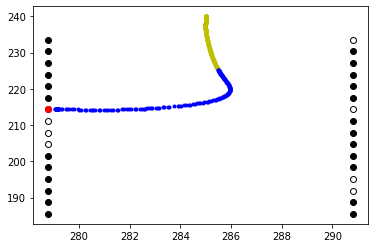

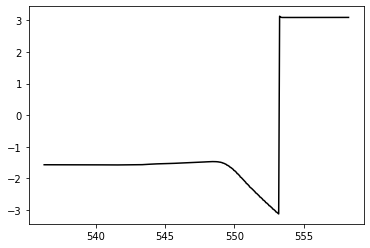

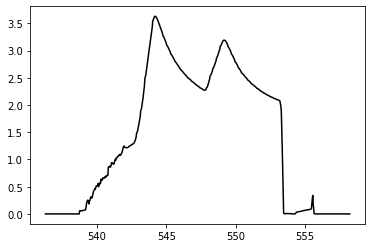

In [5]:
ego_control_dict =  extract_control_info(res_dict)

plt.figure()
plt.plot(ego_control_dict['t'], ego_control_dict['reverse'], 'c')
plt.plot(ego_trajectory[:,0], ego_trajectory[:,4], 'b')
plt.axvspan(ego_trajectory[0,0], ego_trajectory[start_ind,0], alpha=0.5, color='r')
plt.axvspan(ego_trajectory[start_ind,0], ego_trajectory[switch_ind,0], alpha=0.1, color='y')
plt.axvspan(ego_trajectory[switch_ind,0], ego_trajectory[end_ind,0], alpha=0.1, color='b')
plt.axvspan(ego_trajectory[end_ind,0], ego_trajectory[-1,0], alpha=0.5, color='r')

plt.figure()
plt.plot(ego_trajectory[start_ind:switch_ind,1], \
         ego_trajectory[start_ind:switch_ind,2], \
         'y.')
plt.plot(ego_trajectory[switch_ind:end_ind,1], \
         ego_trajectory[switch_ind:end_ind,2], \
         'b.')
for goal in goals:
    if goal[2] > 0:
        plt.plot(goal[0], goal[1], 'ko', fillstyle='none')
    else:
        plt.plot(goal[0], goal[1], 'ko')
        
plt.plot(goals[goal_ind,0], goals[goal_ind,1], 'ro')

plt.figure()
plt.plot(ego_trajectory[:,0], ego_trajectory[:,3], 'k')

plt.figure()
plt.plot(ego_trajectory[:,0], ego_trajectory[:,4], 'k')

# print(ego_trajectory[:,3])

In [6]:
def interpolate_heading(t_interp, t_ref, psi_ref):
    raise NotImplementedError("TODO") 

def interpolate_ego_trajectory(ego_trajectory, t_interp, switch_ind, include_intent = False):
    x_interp = np.interp(t_interp, ego_trajectory[:,0], ego_trajectory[:,1])
    y_interp = np.interp(t_interp, ego_trajectory[:,0], ego_trajectory[:,2]) 
    heading_interp = np.interp(t_interp, ego_trajectory[:,0], ego_trajectory[:,3]) # TODO:wraparound issue
    v_interp = np.interp(t_interp, ego_trajectory[:,0], ego_trajectory[:,4])
    yawrate_interp = np.interp(t_interp, ego_trajectory[:,0], ego_trajectory[:,5])
    
    if include_intent:
        if np.max(t_interp) >= ego_trajectory[switch_ind,0]:
            intent = ego_trajectory[switch_ind, 6] * np.ones(x_interp.shape)
        else:
            intent = -1 * np.ones(x_interp.shape)
            
        return np.column_stack((x_interp, y_interp, heading_interp, v_interp, yawrate_interp, intent))
    else:
        return np.column_stack((x_interp, y_interp, heading_interp, v_interp, yawrate_interp))
    
def get_ego_trajectory_prediction_snippets(ego_trajectory, start_ind, switch_ind, end_ind, goal_ind, goals,\
                                           Nhist=5, Npred=20, Nskip=5, dt=0.1, ego_frame=False):
    features = []; labels = []; goal_snpts = []
    
    t_range_start = ego_trajectory[start_ind, 0] + Nhist * dt
    t_range_end   = ego_trajectory[end_ind, 0] - Npred * dt
    t_skip = Nskip * dt
    print(np.array(goals).shape)
    
    for t_snippet in np.arange(t_range_start, t_range_end + 0.5 * t_skip, t_skip):
        t_hist = [x*dt + t_snippet for x in range(-Nhist + 1, 1)] # -N_hist + 1, ... , 0 -> N_hist steps
        t_pred = [x*dt + t_snippet for x in range(1, Npred+1)] # 1, ..., N_pred -> N_pred steps
    
        feature = interpolate_ego_trajectory(ego_trajectory, t_hist, switch_ind, include_intent=False)
        label   = interpolate_ego_trajectory(ego_trajectory, t_pred, switch_ind, include_intent=True)
        features.append(feature)
        labels.append(label)
        goal_snpts.append(goals.copy())
        
    print(np.array(goal_snpts).shape)
    goal_snpts = np.array(goal_snpts)
#     Transform all snippets into ego frame, if ego_frame=True
    if ego_frame:
        for id_snpt in range(len(features)):
            current = features[id_snpt][-1, :].copy()
            for id_f in range(Nhist):
                features[id_snpt][id_f, :3] -= current[0:3]
                
            for id_l in range(Npred):
                labels[id_snpt][id_l, :3] -= current[0:3]
            
            for id_g in range(len(goals)):
                goal_snpts[id_snpt][id_g, 0:2] -= current[0:2]
                
    return features, labels, goal_snpts

(32, 3)
(30, 32, 3)
Feature Example
 [[-0.     0.024  0.001  0.057  0.014]
 [-0.     0.021  0.001  0.061  0.014]
 [-0.     0.017  0.001  0.067  0.014]
 [-0.     0.012  0.001  0.073  0.014]
 [ 0.     0.     0.     0.201 -0.013]]
Label Example
 [[-2.441e-04 -2.364e-02  4.698e-04  2.508e-01  9.299e-03 -1.000e+00]
 [-3.662e-04 -4.324e-02  8.479e-04  2.403e-01  1.483e-02 -1.000e+00]
 [-3.662e-04 -7.047e-02  9.309e-04  3.111e-01  6.908e-03 -1.000e+00]
 [-3.357e-04 -9.966e-02  8.288e-04  3.078e-01  1.316e-02 -1.000e+00]
 [-4.272e-04 -1.377e-01  9.112e-04  4.183e-01  1.245e-02 -1.000e+00]
 [-6.104e-04 -1.820e-01  1.261e-03  4.652e-01  9.189e-03 -1.000e+00]
 [-3.357e-04 -2.296e-01  4.880e-04  5.157e-01  9.379e-03 -1.000e+00]
 [-3.052e-05 -2.814e-01 -6.442e-04  5.145e-01 -2.226e-02 -1.000e+00]
 [-1.221e-04 -3.349e-01 -6.691e-04  5.437e-01 -1.173e-02 -1.000e+00]
 [-3.052e-05 -3.906e-01 -1.424e-03  5.568e-01 -2.852e-02 -1.000e+00]
 [ 3.052e-05 -4.510e-01 -2.035e-03  6.135e-01 -2.005e-02 -1.000e+00

/home/mpc/anaconda3/envs/carla_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


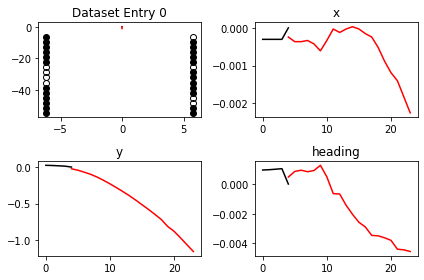

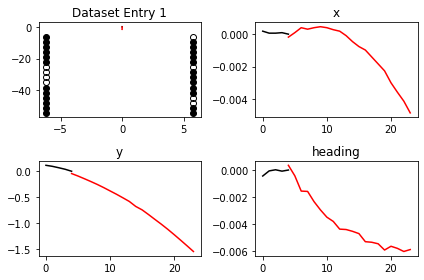

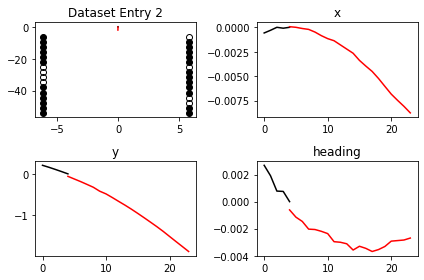

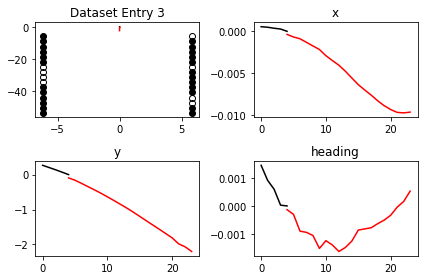

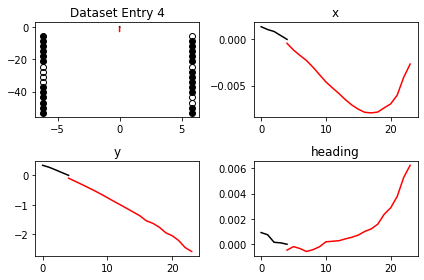

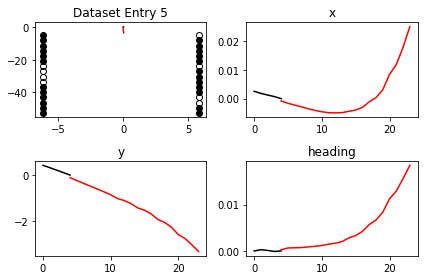

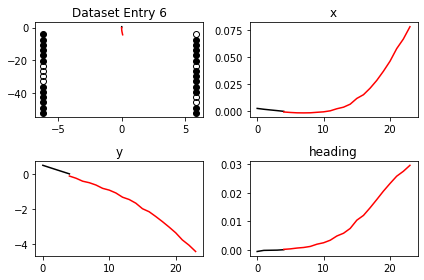

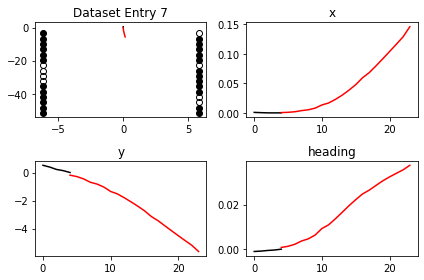

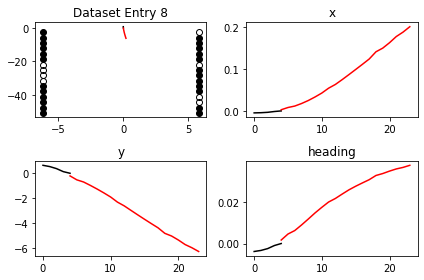

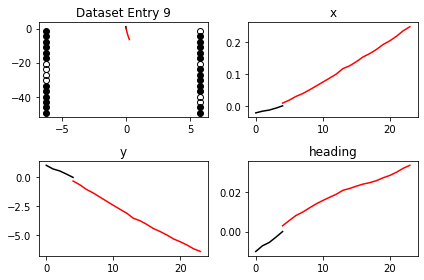

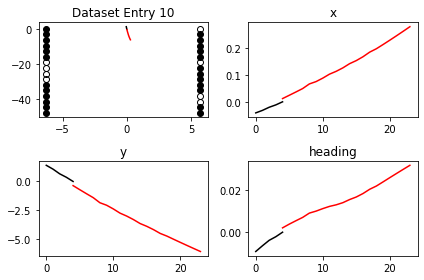

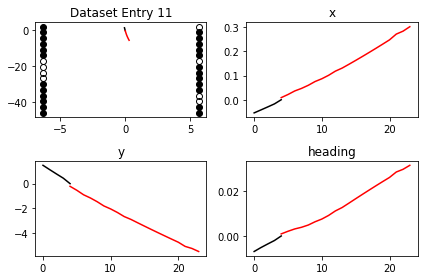

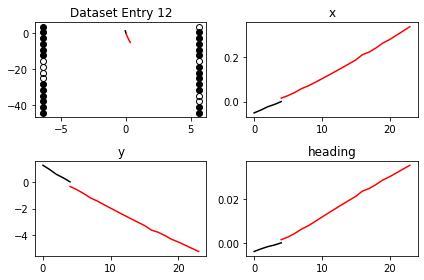

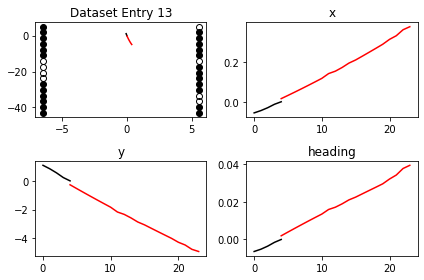

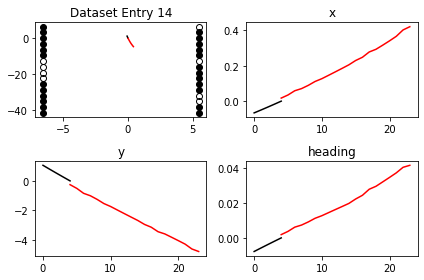

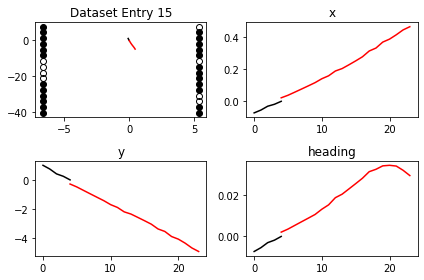

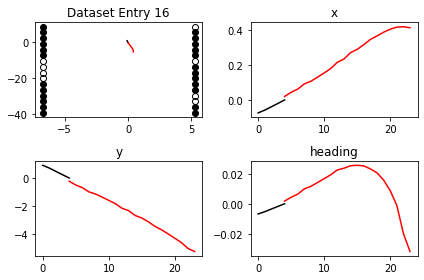

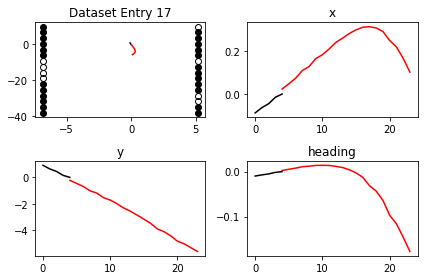

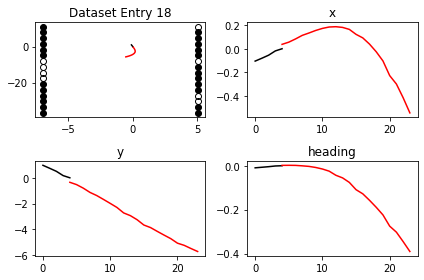

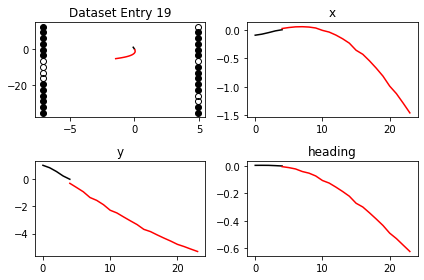

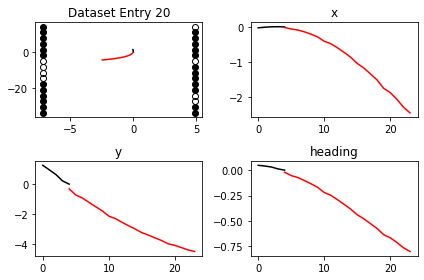

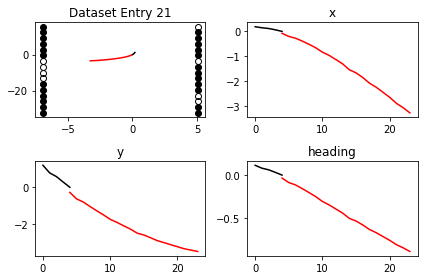

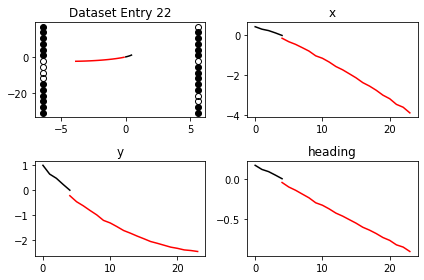

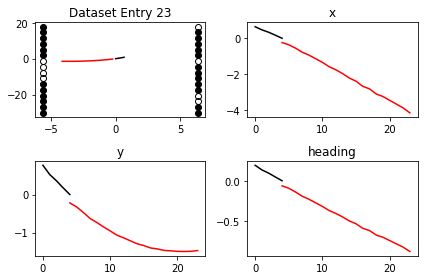

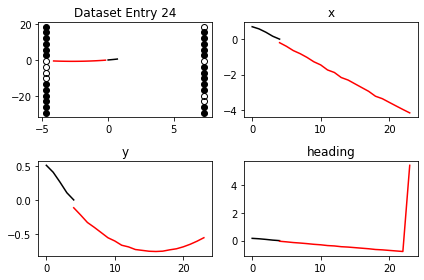

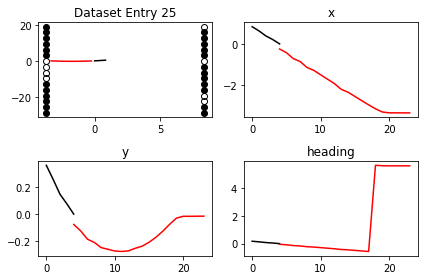

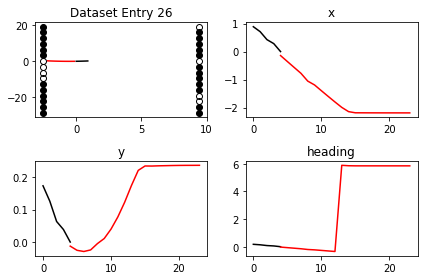

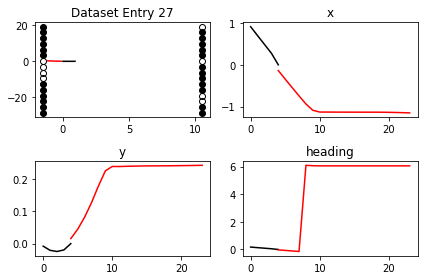

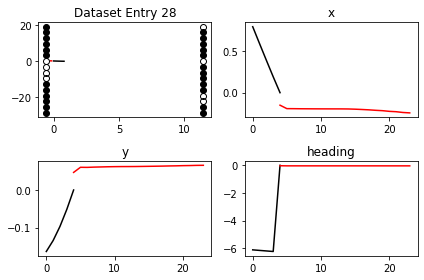

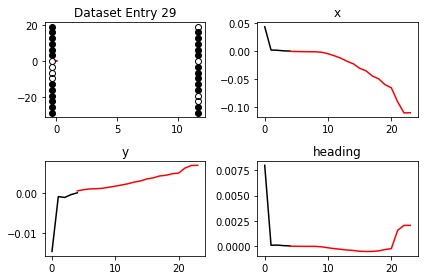

In [7]:
ego_trans = True
features, labels, goal_snpts = get_ego_trajectory_prediction_snippets(ego_trajectory, start_ind, switch_ind, end_ind, goal_ind, \
                                                          goals, ego_frame=ego_trans)

# print(goal_snpts)    

np.set_printoptions(precision=3)
print('Feature Example\n', features[0])
print('Label Example\n', labels[0])

Nhist = 5
Npred = 20

for i in range(0, len(features)):
    plt.figure()
    plt.subplot(221)
    plt.plot(features[i][:,0], features[i][:,1], 'k')
    plt.plot(labels[i][:,0], labels[i][:,1], 'r')
    
    for goal in goal_snpts[i]:
        if goal[2] > 0:
            plt.plot(goal[0], goal[1], 'ko', fillstyle='none')
        else:
            plt.plot(goal[0], goal[1], 'ko')
    plt.title('Dataset Entry %d' % i)
    
    plt.subplot(222)
    
    plt.plot(range(Nhist), features[i][:,0], 'k')
    plt.plot(range(Nhist-1, Nhist+Npred-1), labels[i][:,0], 'r')
    plt.title('x')
    
    plt.subplot(223)
    plt.plot(range(Nhist), features[i][:,1], 'k')
    plt.plot(range(Nhist-1, Nhist+Npred-1), labels[i][:,1], 'r')
    plt.title('y')
    
    plt.subplot(224)
    plt.plot(range(Nhist), features[i][:,2], 'k')
    plt.plot(range(Nhist-1, Nhist+Npred-1), labels[i][:,2], 'r')
    plt.title('heading')
    
    plt.tight_layout()